In [8]:
%matplotlib inline

import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

In [10]:
with open('seasons.pickle') as f:
    seasons = pickle.load(f)
for year, season in seasons.iteritems():
    print year,
    season.load_scores()

2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018


In [11]:
season2018 = seasons['2018']

In [5]:
with open('pd_data/name_fixes_all.json') as f:
    name_fixes = json.load(f)

In [28]:
elements_pred = pd.read_csv('fits/men_multi_elts_1.csv')
components_pred = pd.read_csv('fits/men_multi_comp_1.csv')

In [89]:
len(components_pred[components_pred.points > components_pred.partial_pool_predictions])

1226

In [12]:
# 2018 data
men = pd.read_csv('pd_data/results18_men.csv')
ladies = pd.read_csv('pd_data/results18_ladies.csv')
pairs = pd.read_csv('pd_data/results18_pairs.csv')
dance = pd.read_csv('pd_data/results18_dance.csv')

In [3]:
len(men), len(ladies), len(pairs), len(dance)

(142, 137, 77, 109)

In [3]:
with open('pd_data/name_fixes_all.json') as f:
    name_fixes = json.load(f)

In [45]:
history = pd.read_csv('pd_data/results_nowd_nofra15_dance.csv')

In [46]:
history.Name = history.apply(lambda row: name_fixes.get(row.Name, row.Name), axis=1)

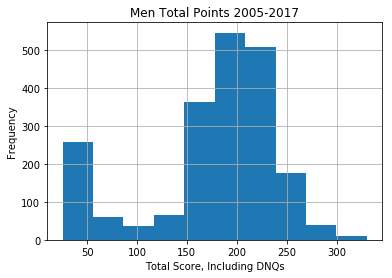

In [27]:
history.Points.hist()
plt.title('Men Total Points 2005-2017')
plt.xlabel('Total Score, Including DNQs')
plt.ylabel('Frequency')

In [13]:
def get_comparison(estimate_type):
    comparison = []
    for event in season2018.events:
        event_name = event.name
        elts = elements_pred[elements_pred.event == event_name].groupby('skater')[estimate_type].sum()
        comp_short = 0.8 * components_pred[components_pred.segment == event_name + ' men_short'].groupby('skater')[estimate_type + 's'].sum()
        comp_free = 1.6 * components_pred[components_pred.segment == event_name + ' men_free'].groupby('skater')[estimate_type + 's'].sum()
        predictions = {}
        outcomes = {}
        total_score = elts + comp_short
        for skater in total_score.index:
            predictions[skater] = total_score.ix[skater]
            if skater in comp_free.index:
                predictions[skater] += comp_free.ix[skater]
        for index, row in men[men.Event == event_name][['Name', 'Points']].iterrows():
            outcomes[row.Name] = row.Points
        comparison.append((predictions, outcomes))
    return comparison

In [14]:
def get_ranks(result_dict):
    ranks = {}
    for (i, (skater, _)) in enumerate(sorted(result_dict.iteritems(), key=lambda (k,v): -1 * v)):
        ranks[skater] = i+1
    return ranks

In [15]:
def calculate_loss(comparison):
    score_difference = 0.
    rank_mistake = 0
    rank_miss = {}
    top6_loss = 0
    top6_miss = {}
    num_below = 0
    for i, (predictions, outcomes) in enumerate(comparison):
        for skater in predictions:
            if predictions[skater] < outcomes[skater]:
                num_below += 1
            score_difference += (predictions[skater] - outcomes[skater])**2
            if pd.isnull(score_difference):
                print i, skater
        predicted_ranks = get_ranks(predictions)
        actual_ranks = get_ranks(outcomes)
        for skater in predictions:
            diff = abs(predicted_ranks[skater] - actual_ranks[skater])
            if diff:
                if skater not in rank_miss:
                    rank_miss[skater] = []
                rank_miss[skater].append((predicted_ranks[skater], actual_ranks[skater]))
                rank_mistake += diff
            if predicted_ranks[skater] <= 6 or actual_ranks[skater] <= 6:
                diff = abs(predicted_ranks[skater] - actual_ranks[skater])
                if diff:
                    if skater not in top6_miss:
                        top6_miss[skater] = []
                    top6_miss[skater].append((predicted_ranks[skater], actual_ranks[skater]))
                    top6_loss += diff
    print num_below
    return score_difference, rank_mistake, rank_miss, top6_loss, top6_miss

In [53]:
best = {skater: np.max(history[history.Name == skater].Points) for skater in history.Name.unique()}

In [54]:
best_med = np.median(best.values())

In [23]:
reputation_comparison = []
for event in season2018.events:
    competition = men[men.Event == event.name]
    predictions = {}
    outcomes = {}
    for index, row in competition.iterrows():
        predictions[row.Name] = best_med if row.Name not in best else best[row.Name]
        outcomes[row.Name] = row.Points
    reputation_comparison.append((predictions, outcomes))

In [25]:
calculate_loss(reputation_comparison)

(385985.75739999989,
 454,
 {'Abzal RAKIMGALIEV': [(18, 23)],
  'Adam RIPPON': [(5, 2)],
  'Alexander MAJOROV': [(12, 7)],
  'Alexander MASZLJANKO': [(36, 33)],
  'Alexander PETROV': [(9, 11)],
  'Alexander SAMARIN': [(8, 3), (8, 4), (9, 6)],
  'Alexei BYCHENKO': [(3, 5)],
  'Andrei LAZUKIN': [(11, 10)],
  'Andrew DODDS': [(25, 21)],
  'Boyang JIN': [(2, 4), (2, 1)],
  'Brendan KERRY': [(7, 11)],
  'Burak DEMIRBOGA': [(22, 23)],
  'Chafik BESSEGHIER': [(10, 11)],
  'Chih-I TSAO': [(19, 17)],
  'Conor STAKELUM': [(25, 36)],
  'Daniel Albert NAURITS': [(19, 21)],
  'Daniel SAMOHIN': [(10, 12), (10, 11), (8, 26)],
  'Davide LEWTON BRAIN': [(21, 31)],
  'Denis TEN': [(3, 9), (3, 8), (3, 15)],
  'Deniss VASILJEVS': [(7, 6), (7, 4)],
  'Dmitri ALIEV': [(12, 6), (11, 8), (20, 2)],
  'Donovan CARRILLO': [(22, 18)],
  'Elladj BALDE': [(14, 8)],
  'Felipe MONTOYA': [(16, 20)],
  'Geon Hyeong AN': [(24, 20)],
  'Grant HOCHSTEIN': [(9, 11), (8, 9), (12, 11)],
  'Han YAN': [(3, 5), (3, 5), (4, 10)]

In [16]:
score_differences = {}
rank_mistakes = {}
rank_misses = {}

In [56]:
# for estimate_type in ('pooled_prediction', 'unpooled_prediction', 'partial_pool_prediction'):
#     comparison = get_comparison(estimate_type)
#     score_difference, rank_mistake, rank_miss, top6_loss, top6_miss = calculate_loss(comparison)
#     score_differences[estimate_type] = score_difference
#     rank_mistakes[estimate_type] = rank_mistake
#     rank_misses[estimate_type] = rank_miss

In [35]:
rank_mistakes, score_differences

({'partial_pool_prediction': 302,
  'pooled_prediction': 376,
  'unpooled_prediction': 380},
 {'partial_pool_prediction': 91053.292305282477,
  'pooled_prediction': 204946.19175774002,
  'unpooled_prediction': 140457656.8769297})

In [83]:
with open('fits/ladies_reputation_start_pred.csv') as f:
    short_pred, free_pred = pickle.load(f)

In [21]:
men.Event.unique()

array(['gprus2017', 'gpcan2017', 'gpchn2017', 'gpjpn2017', 'gpfra2017',
       'gpusa2017', 'gpf1718', 'ec2018', 'fc2018'], dtype=object)

In [57]:
individual_bests_short = {skater: np.max(map(float, history[history.Name == skater]['Short Score']))
                          for skater in history.Name.get_values()}
len(individual_bests_short)

242

In [58]:
have_frees = history[history['Free Rank'] != 'DNQ']
have_frees = have_frees[have_frees['Free Rank'] != 'WD']
individual_bests_free = {skater: np.max(map(float, have_frees[have_frees.Name == skater]['Free Score']))
                         for skater in have_frees.Name.get_values()}
len(individual_bests_free)

203

In [59]:
med_short = np.median(individual_bests_short.values())
med_free = np.median(individual_bests_free.values())
med_short, med_free

(45.730000000000004, 78.920000000000002)

In [60]:
dance['Short Best'] = dance.apply(lambda row: med_short if row.Name not in individual_bests_short else individual_bests_short[row.Name], axis=1)
dance['Free Best'] = dance.apply(lambda row: med_free if row.Name not in individual_bests_free else individual_bests_free[row.Name], axis=1)

In [61]:
def predict_short(row):
    prediction =  11.1460 #26.6549 # 21.8275 # 20.8236
    best = med_short
    if row.Name in individual_bests_short:
        best = individual_bests_short[row.Name]
    prediction += best * 0.8128# 0.5133 # 0.5289 # 0.6155 * best
    return prediction + float(row['Short Start']) / row['Num Short Scorecards'] * 3.8923# 10.4161 # 10.5243 # 12.3222

def predict_free(row):
    if pd.isnull(row['Free Start']):
        return 0.
    prediction = 21.5212# 57.2884 # 71.8259 # 72.3915 
    best = med_free
    if row.Name in individual_bests_free:
        best = individual_bests_free[row.Name]
    prediction += best * 0.7030#0.3892 # 0.1939 # 0.3983
    return prediction + float(row['Free Start']) / row['Num Free Scorecards'] * 12.6694# 28.9112 # 35.1033 # 35.2871

In [62]:
dance['pred_ols_short'] = dance.apply(predict_short, axis=1)

In [63]:
dance['pred_ols_free'] = dance.apply(predict_free, axis=1)

In [67]:
ols_comparison = []
for event in seasons['2018'].events:
    competition = dance[dance.Event == event.name]
    predictions = {}
    outcomes = {}
    for index, row in competition.iterrows():
        predictions[row.Name] = row.pred_ols_short + row.pred_ols_free
    for index, row in competition.iterrows():
        outcomes[row.Name] = row.Points
    ols_comparison.append((predictions, outcomes))

In [68]:
score_difference_ols, rank_mistake_ols, rank_misses_ols, olstop6loss, olstop6miss = calculate_loss(ols_comparison)
score_differences['ols'] = score_difference_ols
rank_misses['ols'] = rank_misses_ols
rank_mistakes['ols'] = rank_mistake_ols

In [41]:
score_differences

{'ols': 50237.52214114873,
 'partial_pool_prediction': 91053.292305282477,
 'pooled_prediction': 204946.19175774002,
 'prediction2': 57355.614637460247,
 'prediction2.5': 44330.506868762561,
 'unpooled_prediction': 140457656.8769297}

In [43]:
rank_mistakes

{'ols': 308,
 'partial_pool_prediction': 302,
 'pooled_prediction': 376,
 'prediction2': 316,
 'prediction2.5': 330,
 'unpooled_prediction': 380}

In [17]:
def get_comparison_combined(df, discipline_df, discipline_name):
    discipline = discipline_name
    comparison = []
    comparison_programs = []
    for event in season2018.events[:-1]:
        # Predictions for this event.
        predictions = {}; outcomes = {}
        short_pred = {}; short_outcome = {}
        free_pred = {}; free_outcome = {}
        
        event_name = event.name
        short = df[df.segment == event_name + ' ' + discipline + '_short']
        free = df[df.segment == event_name + ' ' + discipline + '_free']
        
        # Predict elements and components
        short_elts = short[short.is_elt == 1].groupby('skater').prediction.sum()
        free_elts = free[free.is_elt == 1].groupby('skater').prediction.sum()
        factor_short = 0.8
        factor_free = 1.6
        if discipline_name == 'men':
            factor_short = 1.0
            factor_free = 2.0
        if 'dance' in discipline_name:
            factor_free = 1.2
        comp_short = factor_short * short[short.is_elt == 0].groupby('skater').prediction.sum()
        comp_free = factor_free * free[free.is_elt == 0].groupby('skater').prediction.sum()

        # Predict total scores.
        short_score = short_elts + comp_short
        free_score = free_elts + comp_free
        total_score = short_score + free_score
        for skater in total_score.index:
            predictions[skater] = short_score.loc[skater]
            short_pred[skater] = short_score.loc[skater]
            if skater in free_score.index:
                predictions[skater] += free_score.loc[skater]
                free_pred[skater] = free_score.loc[skater]
        for index, row in discipline_df[discipline_df.Event == event_name][['Name', 'Points', 'Short Score', 'Free Score']].iterrows():
            outcomes[row.Name] = row.Points
            short_outcome[row.Name] = row['Short Score']
            if not pd.isnull(row['Free Score']):
                free_outcome[row.Name] = row['Free Score']
        comparison.append((predictions, outcomes))
        comparison_programs.append((short_pred, short_outcome, free_pred, free_outcome))
    return comparison, comparison_programs

In [18]:
def read_csv_and_calculate(discipline_str, model_num, discipline_df):
    predictions = pd.read_csv('fits/{0}_predictions{1}.csv'.format(discipline_str, model_num))
    dict_str = 'prediction' + model_num
    if discipline_str == 'dance':
        discipline_str = 'ice_dance'
    score_differences[dict_str], rank_mistakes[dict_str], rank_misses[dict_str], top6loss, top6miss = calculate_loss(
        get_comparison_combined(predictions, discipline_df, discipline_str)[0])
    return top6loss, top6miss

In [49]:
rank_misses['prediction3']['Gabriella PAPADAKIS / Guillaume CIZERON'], rank_misses['prediction3']['Tessa VIRTUE / Scott MOIR']

([(2, 1)], [(1, 2)])

In [46]:
set(rank_misses['prediction3'].keys()).difference(rank_misses['prediction1'])

{'Chantelle KERRY / Andrew DODDS'}

In [47]:
for k in rank_misses['prediction1']:
    if k not in rank_misses['prediction3']:
        continue
    if rank_misses['prediction1'][k] != rank_misses['prediction3'][k]:
        print k, rank_misses['prediction1'][k], rank_misses['prediction3'][k]
    

Haley SALES / Nikolas WAMSTEEKER [(10, 9)] [(11, 9)]
Kana MURAMOTO / Chris REED [(7, 9), (2, 3)] [(8, 9), (2, 3)]
Elliana POGREBINSKY / Alex BENOIT [(5, 7), (6, 7)] [(4, 7), (6, 7)]
Sara HURTADO / Kirill KHALIAVIN [(11, 8)] [(12, 8)]
Misato KOMATSUBARA / Tim KOLETO [(11, 10)] [(9, 10)]
Sarah ARNOLD / Thomas WILLIAMS [(9, 8)] [(13, 8)]
Shiyue WANG / Xinyu LIU [(4, 5)] [(3, 5)]
Rachel PARSONS / Michael PARSONS [(10, 7), (7, 6)] [(10, 7), (8, 6)]
Lorraine MCNAMARA / Quinn CARPENTER [(9, 5), (8, 4)] [(9, 5), (7, 4)]
Teodora MARKOVA / Simon DAZE [(24, 26)] [(27, 26)]
Alexandra NAZAROVA / Maxim NIKITIN [(8, 6), (10, 11)] [(9, 6)]
Rikako FUKASE / Aru TATENO [(12, 11)] [(10, 11)]
Penny COOMES / Nicholas BUCKLAND [(9, 7), (12, 7)] [(6, 7)]
Ekaterina BOBROVA / Dmitri SOLOVIEV [(3, 2)] [(1, 2), (3, 2)]
Tiffani ZAGORSKI / Jonathan GUERREIRO [(5, 6)] [(5, 4), (9, 6)]
Guoste DAMULEVICIUTE / Deividas KIZALA [(25, 24)] [(28, 24)]
Justyna PLUTOWSKA / Jeremie FLEMIN [(27, 21)] [(24, 21)]
Viktoria KAVALI

In [41]:
score_differences, rank_mistakes

({'prediction1': 46160.970641071617,
  'prediction2': 22539.8140776603,
  'prediction2.5': 60780.909121012162,
  'prediction3': 20179.989171185687},
 {'prediction1': 170,
  'prediction2': 184,
  'prediction2.5': 430,
  'prediction3': 170})

In [36]:
rank_misses

{'prediction1': {'Alexa SCIMECA KNIERIM / Chris KNIERIM': [(4, 5)],
  'Aljona SAVCHENKO / Bruno MASSOT': [(1, 2)],
  'Annika HOCKE / Ruben BLOMMAERT': [(11, 8)],
  'Ashley CAIN / Timothy LEDUC': [(5, 6), (3, 2)],
  'Camille RUEST / Andrew WOLFE': [(5, 7)],
  'Cheng PENG / Yang JIN': [(3, 5), (2, 5)],
  'Deanna STELLATO / Nathan BARTHOLOMAY': [(7, 5)],
  'Evgenia TARASOVA / Vladimir MOROZOV': [(4, 5)],
  'Haven DENNEY / Brandon FRAZIER': [(6, 7)],
  'Ioulia CHTCHETININA / Mikhail AKULOV': [(14, 13)],
  'Julianne SEGUIN / Charlie BILODEAU': [(3, 5), (3, 4)],
  'Kirsten MOORE-TOWERS / Michael MARINARO': [(4, 3), (7, 6)],
  'Kristina ASTAKHOVA / Alexei ROGONOV': [(6, 3), (5, 3)],
  'Ksenia STOLBOVA / Fedor KLIMOV': [(6, 4)],
  'Lana PETRANOVIC / Antonio SOUZA-KORDEIRU': [(8, 12)],
  'Laura BARQUERO / Aritz MAESTU': [(12, 11)],
  'Liubov ILYUSHECHKINA / Dylan MOSCOVITCH': [(5, 6), (3, 4), (1, 4)],
  'Lola ESBRAT / Andrei NOVOSELOV': [(9, 10)],
  'Marissa CASTELLI / Mervin TRAN': [(5, 7), (5

In [26]:
read_csv_and_calculate('men', '3.7', men)

KeyError: 'Harrison J-Ye WONG'

In [17]:
score_differences, rank_mistakes

({'prediction1': 91204.396916166108, 'prediction3': 82093.873964853366},
 {'prediction1': 436, 'prediction3': 408})

In [7]:
score_differences, rank_mistakes

NameError: name 'score_differences' is not defined

In [60]:
rank_misses

{'ols': {'Alexa SCIMECA KNIERIM / Chris KNIERIM': [(3, 5)],
  u'Aljona SAVCHENKO / Bruno MASSOT': [(1, 2), (3, 1)],
  'Annika HOCKE / Ruben BLOMMAERT': [(9, 8)],
  'Ashley CAIN / Timothy LEDUC': [(4, 2)],
  'Cheng PENG / Yang JIN': [(7, 5), (4, 5)],
  'Deanna STELLATO / Nathan BARTHOLOMAY': [(6, 5)],
  'Ekaterina ALEXANDROVSKAYA / Harley WINDSOR': [(3, 6)],
  'Evgenia TARASOVA / Vladimir MOROZOV': [(2, 5), (3, 1)],
  'Haven DENNEY / Brandon FRAZIER': [(6, 7), (6, 7)],
  'Ioulia CHTCHETININA / Mikhail AKULOV': [(12, 13)],
  'Julianne SEGUIN / Charlie BILODEAU': [(4, 5), (5, 4)],
  'Kirsten MOORE-TOWERS / Michael MARINARO': [(7, 6)],
  'Kristina ASTAKHOVA / Alexei ROGONOV': [(5, 3), (4, 3)],
  'Ksenia STOLBOVA / Fedor KLIMOV': [(5, 4)],
  u'Lana PETRANOVIC / Antonio SOUZA-KORDEIRU': [(13, 12)],
  'Liubov ILYUSHECHKINA / Dylan MOSCOVITCH': [(5, 6), (3, 4), (1, 4)],
  'Lola ESBRAT / Andrei NOVOSELOV': [(8, 7), (8, 10)],
  'Meagan DUHAMEL / Eric RADFORD': [(2, 1), (1, 3), (4, 3)],
  'Natali

In [27]:
pred3_5top6loss, pred3top6loss, pred3_6top6loss

(152, 152, 142)

In [28]:
score_differences['prediction3.6'], rank_mistakes['prediction3.6']

(113683.31909386342, 312)

In [23]:
print sum(predictions3_5.apply(lambda row: row.is_elt * (row.prediction - row.points) ** 2, axis=1))
print sum(predictions3_5.apply(lambda row: (1-row.is_elt) * (row.prediction - row.points) ** 2, axis=1))

13335.3586541
564.308975


In [24]:
print sum(predictions3.apply(lambda row: row.is_elt * (row.prediction - row.points) ** 2, axis=1))
print sum(predictions3.apply(lambda row: (1-row.is_elt) * (row.prediction - row.points) ** 2, axis=1))

13335.3586541
791.886569227


In [65]:
compare

,pred_ols_short,Name,Event,pred2_short,real_short,pred2.5_short
0,94.562460,Nathan CHEN,gprus2017,91.440426,100.54,93.932627
1,101.435525,Yuzuru HANYU,gprus2017,94.748954,94.85,97.412413
2,89.532790,Mikhail KOLYADA,gprus2017,83.997503,85.79,86.497190
3,77.609575,Misha GE,gprus2017,74.459113,85.02,76.655197
4,70.178475,Moris KVITELASHVILI,gprus2017,75.456446,80.67,77.297085
5,66.639295,Dmitri ALIEV,gprus2017,62.773720,88.77,66.534029
6,73.937110,Nam NGUYEN,gprus2017,78.579097,80.74,80.932258
7,78.316365,Deniss VASILJEVS,gprus2017,74.894249,82.44,77.623895
8,83.983105,Denis TEN,gprus2017,80.448934,69.00,82.584978
9,59.451345,Andrei LAZUKIN,gprus2017,63.671315,78.54,66.755788


In [191]:
predictions2[predictions2.skater == 'Shoma UNO']

,Unnamed: 0,element,elt_type,event,is_elt,points,prediction,segment,skater,skater_code
240,240,4F,4j,gpcan2017,1,14.59,11.294323,gpcan2017 men_short,Shoma UNO,253
241,241,FCSp4,sp,gpcan2017,1,4.20,4.069687,gpcan2017 men_short,Shoma UNO,253
242,242,StSq3,st,gpcan2017,1,4.44,4.940551,gpcan2017 men_short,Shoma UNO,253
243,243,4T+2T,4j,gpcan2017,1,13.76,10.970014,gpcan2017 men_short,Shoma UNO,253
244,244,3A,3j,gpcan2017,1,11.78,9.069428,gpcan2017 men_short,Shoma UNO,253
245,245,CSSp4,sp,gpcan2017,1,3.71,4.010456,gpcan2017 men_short,Shoma UNO,253
246,246,CCoSp4,sp,gpcan2017,1,4.64,4.061950,gpcan2017 men_short,Shoma UNO,253
324,324,4Lo,4j,gpcan2017,1,14.14,11.108533,gpcan2017 men_free,Shoma UNO,253
325,325,3Lo,3j,gpcan2017,1,4.60,9.120333,gpcan2017 men_free,Shoma UNO,253
326,326,3A,3j,gpcan2017,1,10.50,9.073478,gpcan2017 men_free,Shoma UNO,253
